# Analysis of the UK parliaments interaction network

In this notebook we will analyse the basics structure of the network, including degree and edge weight distribution, finding important 

In [27]:
import pandas as pd
import numpy as np
import utils.graph_builder as graph_builder
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from utils.backbone import high_salience_skeleton, thresholding, disparity_filter
import matplotlib.patches as mpatches

# Constructing graph

In [28]:
file = "uk_parliament_interactions_graph_data_V4.json"

In [29]:
G_full = graph_builder.build_full_graph(file = file)

In [30]:
graph_builder.add_party_grouped_attribute(G_full)

In [31]:
def to_undirected_with_summed_weights(G):
    H = nx.Graph()

    for u, v, data in G.edges(data=True):
        w = data.get("weight", 0)

        if H.has_edge(u, v):
            # Edge already added from opposite direction → add weight
            H[u][v]["weight"] += w
        else:
            # Create edge with initial weight
            H.add_edge(u, v, weight=w)

    return H

In [32]:
# make G_full undeirected
G_full_undirected = to_undirected_with_summed_weights(G_full)

# Analysing basic network structure

In [33]:
num_nodes = len(G_full_undirected.nodes)
num_links = len(G_full_undirected.edges)
num_links_weighted = int(G_full_undirected.size(weight='weight'))
graph_density = nx.density(G_full_undirected)
avg_degree = sum(dict(G_full_undirected.degree()).values()) / num_nodes
avg_shortest_path_length = nx.average_shortest_path_length(G_full_undirected)
longest_path_length = nx.diameter(G_full_undirected)
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Links: {num_links}")
print(f"Number of Weighted Links: {num_links_weighted}")
print(f"Graph Density: {graph_density}")
print(f"Average Degree: {avg_degree}")
print(f"Average Shortest Path Length: {avg_shortest_path_length}")
print(f"Longest Path Length: {longest_path_length}")

Number of Nodes: 665
Number of Links: 30863
Number of Weighted Links: 86039
Graph Density: 0.13979074191502855
Average Degree: 92.82105263157895
Average Shortest Path Length: 1.8751154995923545
Longest Path Length: 4


# Analysing Degree and edge weight distribution

In [34]:
def get_edge_weights(G):
    edge_weights = {}
    for u, v, data in G.edges(data=True):
        edge_weights[(u, v)] = data.get("weight", 0)
    return edge_weights
edge_weights = get_edge_weights(G_full_undirected)

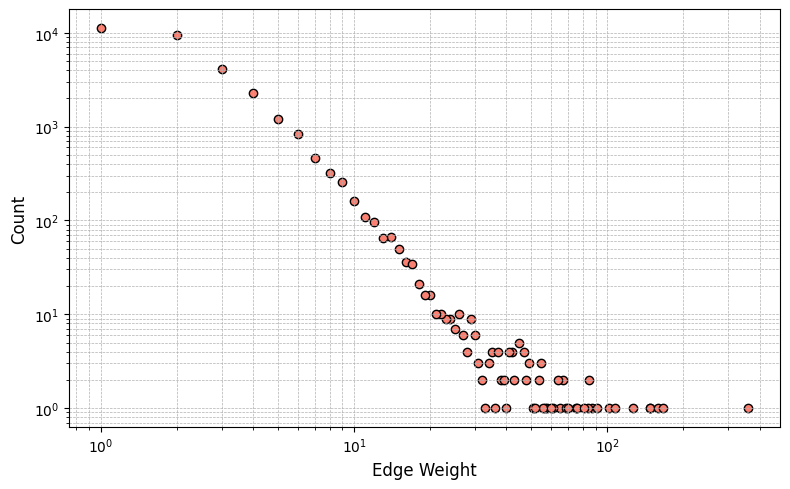

In [35]:
# create scatter log log plot of edge weights
count_weighted_degrees = Counter(edge_weights.values())
weights, counts = zip(*count_weighted_degrees.items())

plt.figure(figsize=(8, 5))
plt.scatter(weights, counts, color='salmon', edgecolor='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Edge Weight", size=12)
plt.ylabel("Count", size=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

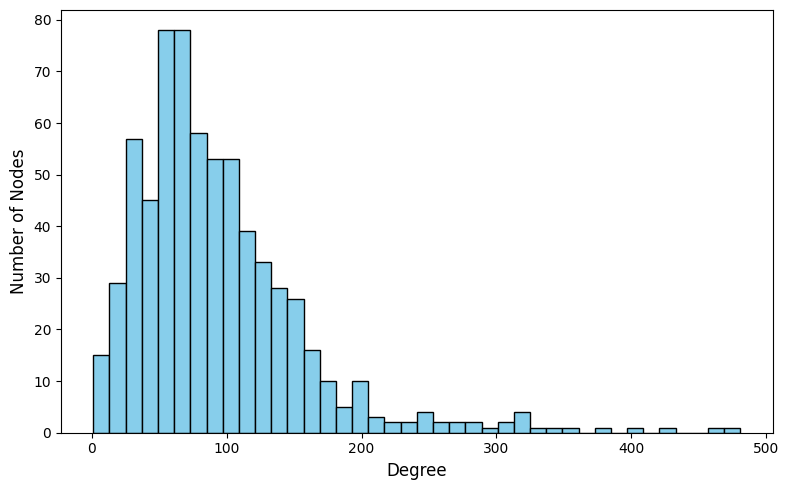

In [36]:
degrees = dict(G_full_undirected.degree())

plt.figure(figsize=(8, 5))

plt.hist(list(degrees.values()), bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Degree", size=12)
plt.ylabel("Number of Nodes", size=12)

plt.tight_layout()
plt.show()

Assortativity reaveals that high degree nodes rather speak to smaller degree nodes -> Members of Council to Backbenchers

In [37]:
assortativity = nx.degree_assortativity_coefficient(G_full)
print("Degree assortativity:", assortativity)

Degree assortativity: -0.17903061524781919


# Degree and Assortativity Analsis

In [38]:
# top 5 connected nodes
top_5_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Connected Nodes (by Degree):")
for node, degree in top_5_nodes:
    print(f"Node: {node}, Degree: {degree}")
    # lookup node name
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")

Top 5 Connected Nodes (by Degree):
Node: 1423, Degree: 481
Node Name: Rt Hon Boris Johnson
Node: 4131, Degree: 457
Node Name: Jim Shannon MP
Node: 467, Degree: 426
Node Name: Rt Hon Sir Lindsay Hoyle MP
Node: 4483, Degree: 408
Node Name: Rt Hon Rishi Sunak MP
Node: 4070, Degree: 383
Node Name: Rt Hon Matt Hancock


In [39]:
in_deg = nx.in_degree_centrality(G_full)
out_deg = nx.out_degree_centrality(G_full)
deg = nx.degree_centrality(G_full)

print("Top 3 by In-degree:")
in_deg_sorted = sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:3]
# print with node names
for node, centrality in in_deg_sorted:
    print(f"Node: {node}, In-degree Centrality: {centrality}")
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")
print()
print("\nTop 3 by Out-degree:")
out_deg_sorted = sorted(out_deg.items(), key=lambda x: x[1], reverse=True)[:3]
for node, centrality in out_deg_sorted:
    print(f"Node: {node}, Out-degree Centrality: {centrality}")
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")
print()
print("\nTop 3 by Degree:")
deg_sorted = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:3]
for node, centrality in deg_sorted:
    print(f"Node: {node}, Degree Centrality: {centrality}")
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")

Top 3 by In-degree:
Node: 1423, In-degree Centrality: 0.7183734939759037
Node Name: Rt Hon Boris Johnson
Node: 4131, In-degree Centrality: 0.625
Node Name: Jim Shannon MP
Node: 4483, In-degree Centrality: 0.6114457831325302
Node Name: Rt Hon Rishi Sunak MP


Top 3 by Out-degree:
Node: 1423, Out-degree Centrality: 0.6265060240963856
Node Name: Rt Hon Boris Johnson
Node: 4131, Out-degree Centrality: 0.6204819277108434
Node Name: Jim Shannon MP
Node: 467, Out-degree Centrality: 0.5256024096385542
Node Name: Rt Hon Sir Lindsay Hoyle MP


Top 3 by Degree:
Node: 1423, Degree Centrality: 1.3448795180722892
Node Name: Rt Hon Boris Johnson
Node: 4131, Degree Centrality: 1.2454819277108435
Node Name: Jim Shannon MP
Node: 4483, Degree Centrality: 1.0512048192771084
Node Name: Rt Hon Rishi Sunak MP


In [40]:
# created inverse edge weight graph
G_full_inv = nx.DiGraph()
for u, v, data in G_full.edges(data=True):
    weight = data.get("weight", 1)
    if weight != 0:
        G_full_inv.add_edge(u, v, weight=1/weight)
    else:
        G_full_inv.add_edge(u, v, weight=0)

In [41]:
bet = nx.betweenness_centrality(G_full_inv)
print("Top 3 by Betweenness Centrality:")
betweeness_sorted = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5]
for node, centrality in betweeness_sorted:
    print(f"Node: {node}, Betweenness Centrality: {centrality}")
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")

Top 3 by Betweenness Centrality:
Node: 1423, Betweenness Centrality: 0.05482047215556819
Node Name: Rt Hon Boris Johnson
Node: 4131, Betweenness Centrality: 0.03922970863287399
Node Name: Jim Shannon MP
Node: 4483, Betweenness Centrality: 0.02912123387628124
Node Name: Rt Hon Rishi Sunak MP
Node: 467, Betweenness Centrality: 0.026733877618685186
Node Name: Rt Hon Sir Lindsay Hoyle MP
Node: 4070, Betweenness Centrality: 0.023491615132322105
Node Name: Rt Hon Matt Hancock


In [42]:
centrality = nx.betweenness_centrality(G_full_inv)

print("Top 5 Connected Nodes:")
centrality_sorted = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for node, cent in centrality_sorted:
    print(f"Node: {node}, Betweenness Centrality: {cent}")
    print(f"Node Name: {G_full.nodes[node]['FullTitle']}")

Top 5 Connected Nodes:
Node: 1423, Betweenness Centrality: 0.05482047215556819
Node Name: Rt Hon Boris Johnson
Node: 4131, Betweenness Centrality: 0.03922970863287399
Node Name: Jim Shannon MP
Node: 4483, Betweenness Centrality: 0.02912123387628124
Node Name: Rt Hon Rishi Sunak MP
Node: 467, Betweenness Centrality: 0.026733877618685186
Node Name: Rt Hon Sir Lindsay Hoyle MP
Node: 4070, Betweenness Centrality: 0.023491615132322105
Node Name: Rt Hon Matt Hancock


# Backbone analysis

In [43]:
G_full_undirected_inv = nx.DiGraph()
for u, v, data in G_full_undirected.edges(data=True):
    weight = data.get("weight", 1)
    if weight != 0:
        G_full_undirected_inv.add_edge(u, v, weight=1/weight)
    else:
        G_full_undirected_inv.add_edge(u, v, weight=0)

In [44]:
party_colors = {
    'Conservative': '#4A90E2',        
    'Labour': '#D0021B',              
    'Liberal Democrat': '#F5A623',    
    'Scottish National Party': '#F8E71C',  
    'Independent': '#7ED321',         
    'Other': '#9B9B9B'               
}

In [45]:
edge_table = nx.to_pandas_edgelist(G_full_undirected_inv)
edge_table.rename(columns={'weight': 'nij', 'source': 'src', 'target': 'trg'}, inplace=True)
edge_table["nij"] = 1.0
hss = high_salience_skeleton(edge_table, undirected=True)
threshold = 0.42
backbone_table = thresholding(hss, threshold=threshold)
print("Number of left over edges in the backbone:", len(backbone_table))
backbone_G = nx.from_pandas_edgelist(backbone_table, source='src', target='trg', edge_attr='nij')

Calculating HSS score...


Number of left over edges in the backbone: 807


In [46]:
def generate_node_sizes(G, deg, min_size=100, max_size=5000):
    deg_values = np.array(list(deg.values()))
    deg_values = np.array([deg[n] for n in G.nodes()])
    norm_sizes = min_size + (deg_values - deg_values.min()) / (deg_values.max() - deg_values.min()) * (max_size - min_size)
    return norm_sizes

In [47]:
G_full.nodes[4131
             ]

{'DisplayAs': 'Jim Shannon',
 'ListAs': 'Shannon, Jim',
 'FullTitle': 'Jim Shannon MP',
 'Gender': 'M',
 'Party': 'Democratic Unionist Party',
 'PartyId': 7,
 'ConstituencyCountry': 'I',
 'Party_Grouped': 'Other'}

/home/max/Documents/uni/SGI/.venv/lib/python3.12/site-packages/networkx/drawing/layout.py:1810: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


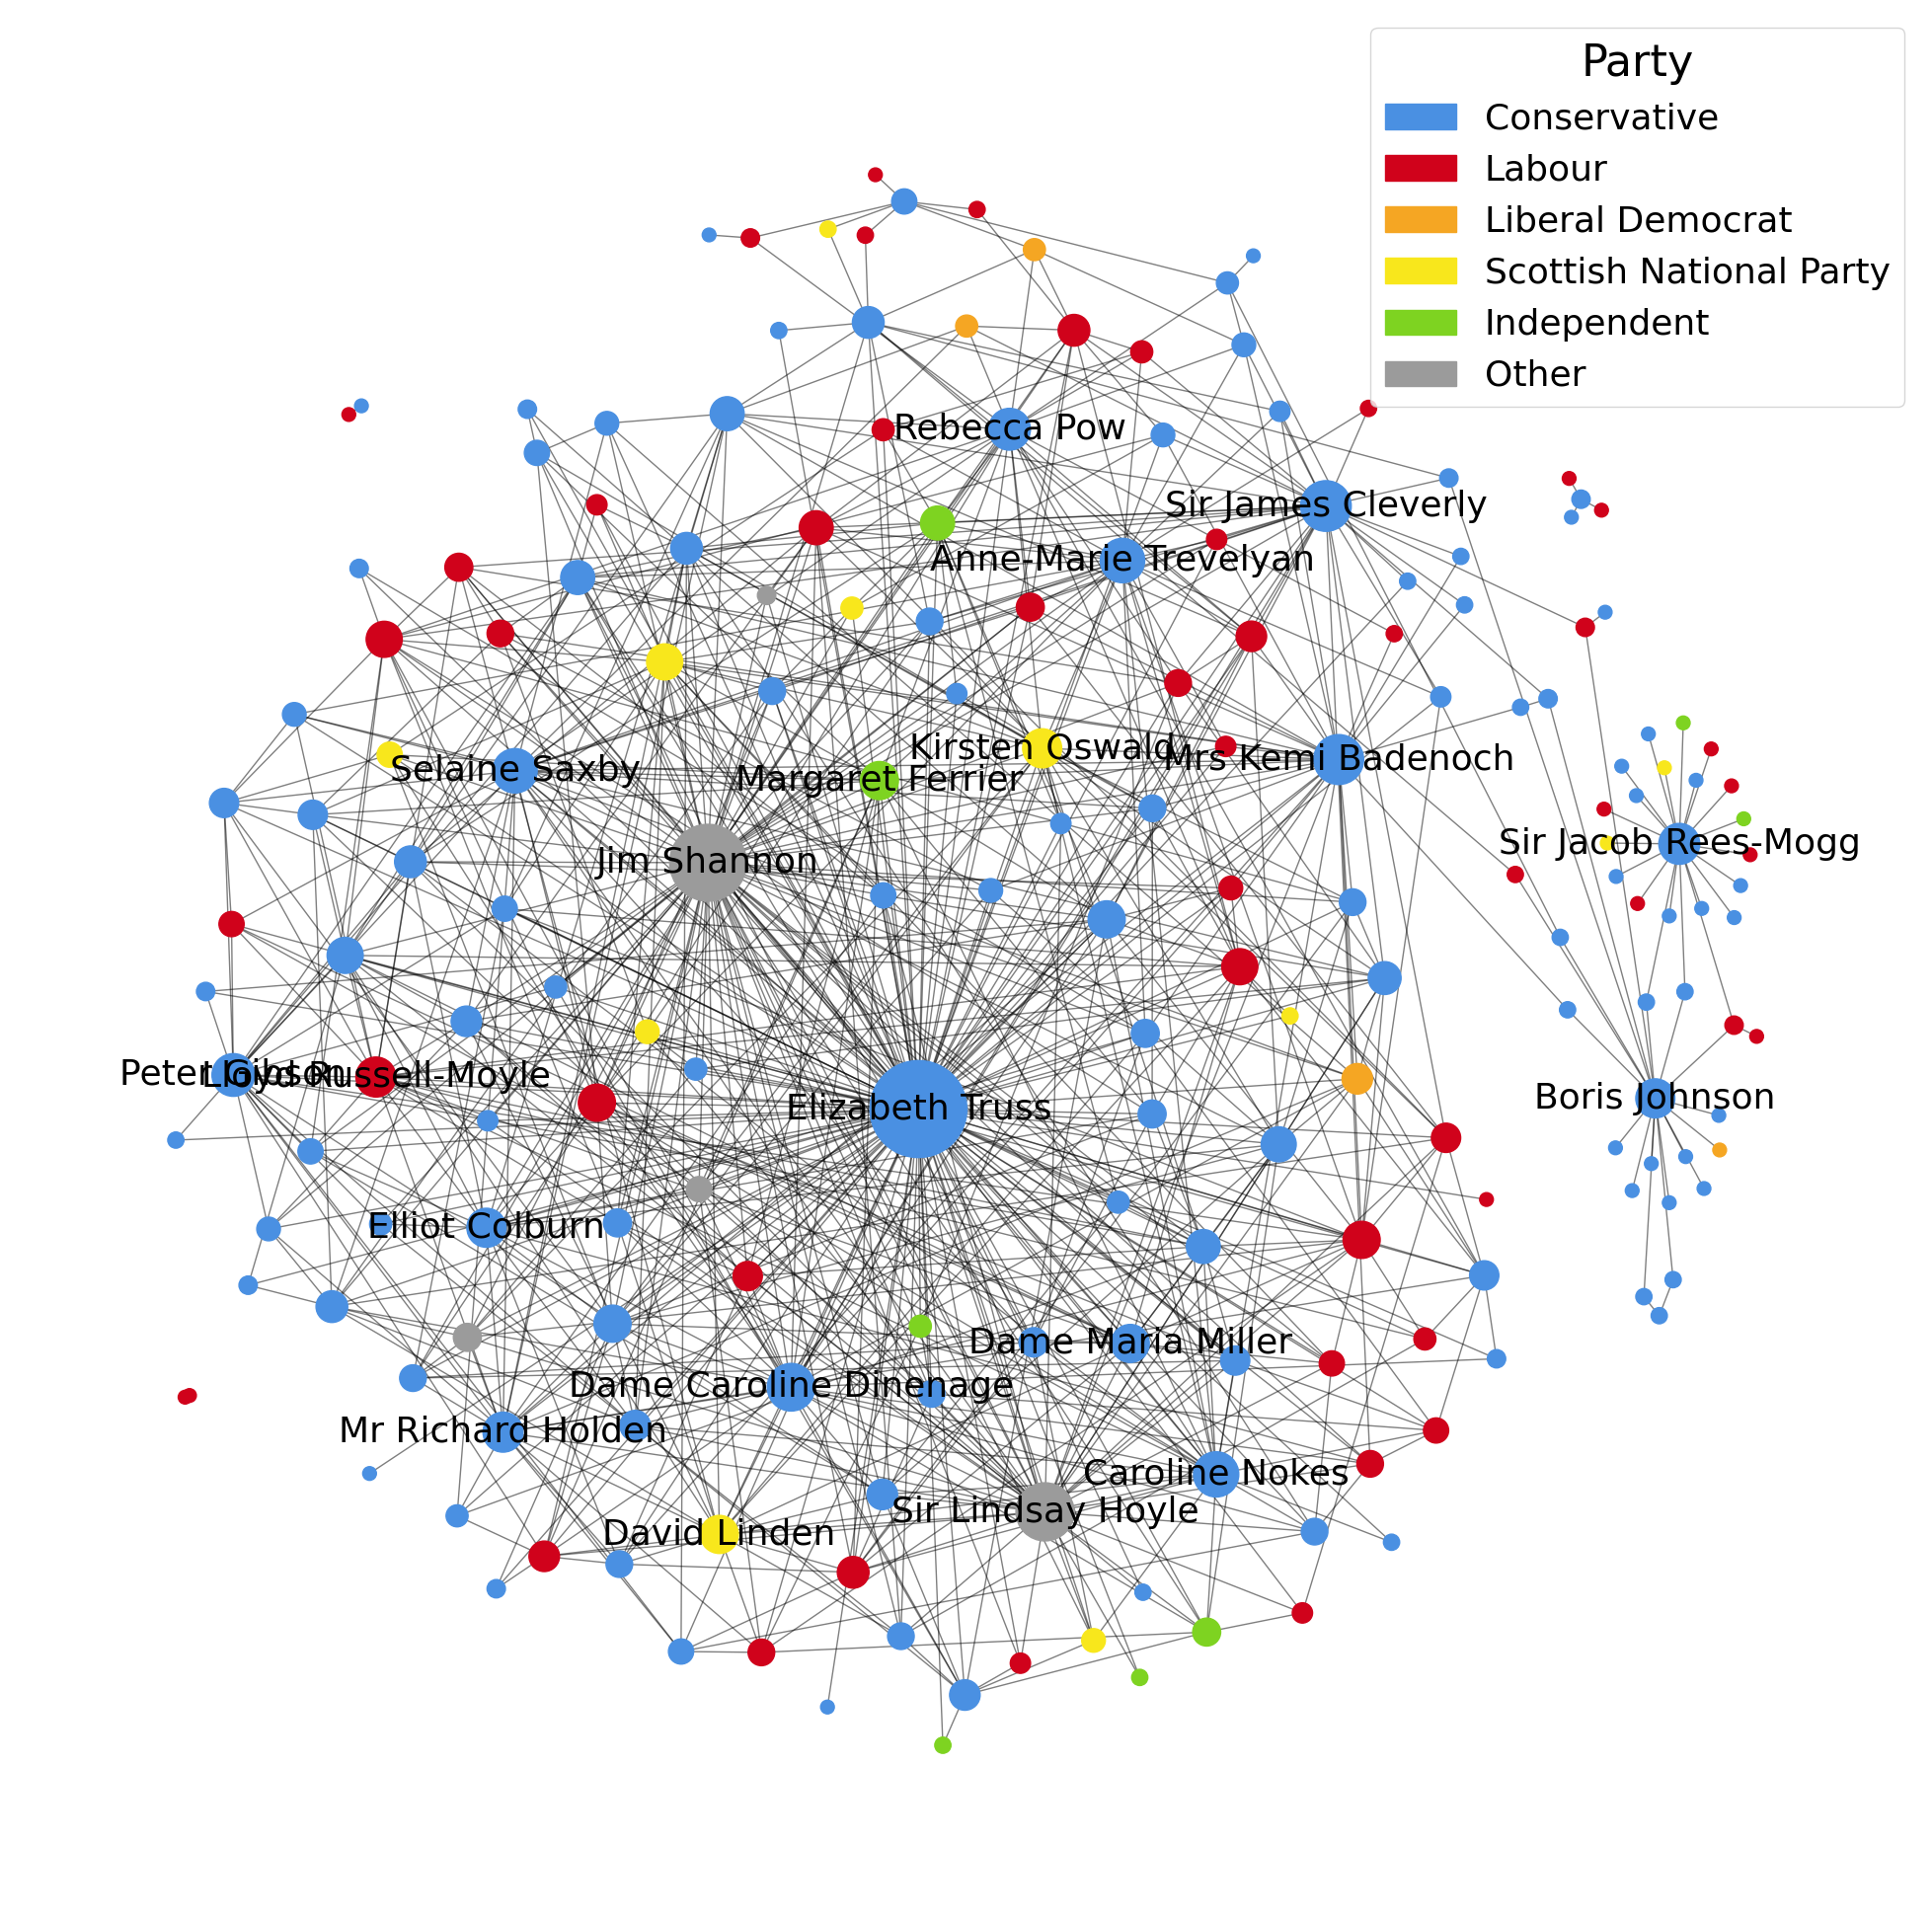

In [48]:
deg = nx.degree_centrality(backbone_G)
pos = nx.forceatlas2_layout(
    backbone_G,
    max_iter=1500,
    scaling_ratio=20.0,
    gravity=0.01,
    strong_gravity=True,
    linlog=True,
    seed=41
)
plt.figure(figsize=(25, 25))

nodes = nx.draw_networkx_nodes(
    backbone_G,
    pos,
    node_size=generate_node_sizes(backbone_G, deg),
    node_color=[party_colors.get(G_full.nodes[n].get("Party_Grouped", "Other"), "gray") for n in backbone_G.nodes()]
)

edges = nx.draw_networkx_edges(backbone_G, pos, alpha=0.5)
top_20_nodes = sorted(deg, key=deg.get, reverse=True)[:20]
top_20_nodes = [n for n in top_20_nodes if n in pos]

top_20_labels = {node: G_full.nodes[node]['DisplayAs'] for node in top_20_nodes}

nx.draw_networkx_labels(backbone_G, pos, labels=top_20_labels, font_size=26)
# add legend for the party colors

legend_handles = [mpatches.Patch(color=color, label=party) for party, color in party_colors.items()]
plt.legend(handles=legend_handles, title="Party", loc="best", fontsize=26, title_fontsize=32)
plt.axis('off')


plt.show()

In [49]:
edge_bc = nx.edge_betweenness_centrality(G_full_undirected)

bc_values = np.array(list(edge_bc.values()))

bc_min = bc_values.min()
bc_max = bc_values.max()
bc_normalized = (bc_values - bc_min) / (bc_max - bc_min)

bc_scaled = bc_normalized * (100 - 1) + 1

bc_inverted = 1 / bc_scaled

weighted_edges_bc = [
    (edge[0], edge[1], weight)
    for edge, weight in zip(edge_bc.keys(), bc_inverted)
]

In [50]:
edge_table = pd.DataFrame(weighted_edges_bc, columns=["src", "trg", "nij"])

dis_filtered = disparity_filter(edge_table, undirected=True)

threshold = 0.32

backbone_table = dis_filtered[dis_filtered["score"] <= threshold]

print("Number of left over edges in the backbone:", len(backbone_table))

backbone_G = nx.from_pandas_edgelist(backbone_table, source='src', target='trg', edge_attr='nij')

Number of left over edges in the backbone: 476


Calculating DF score...


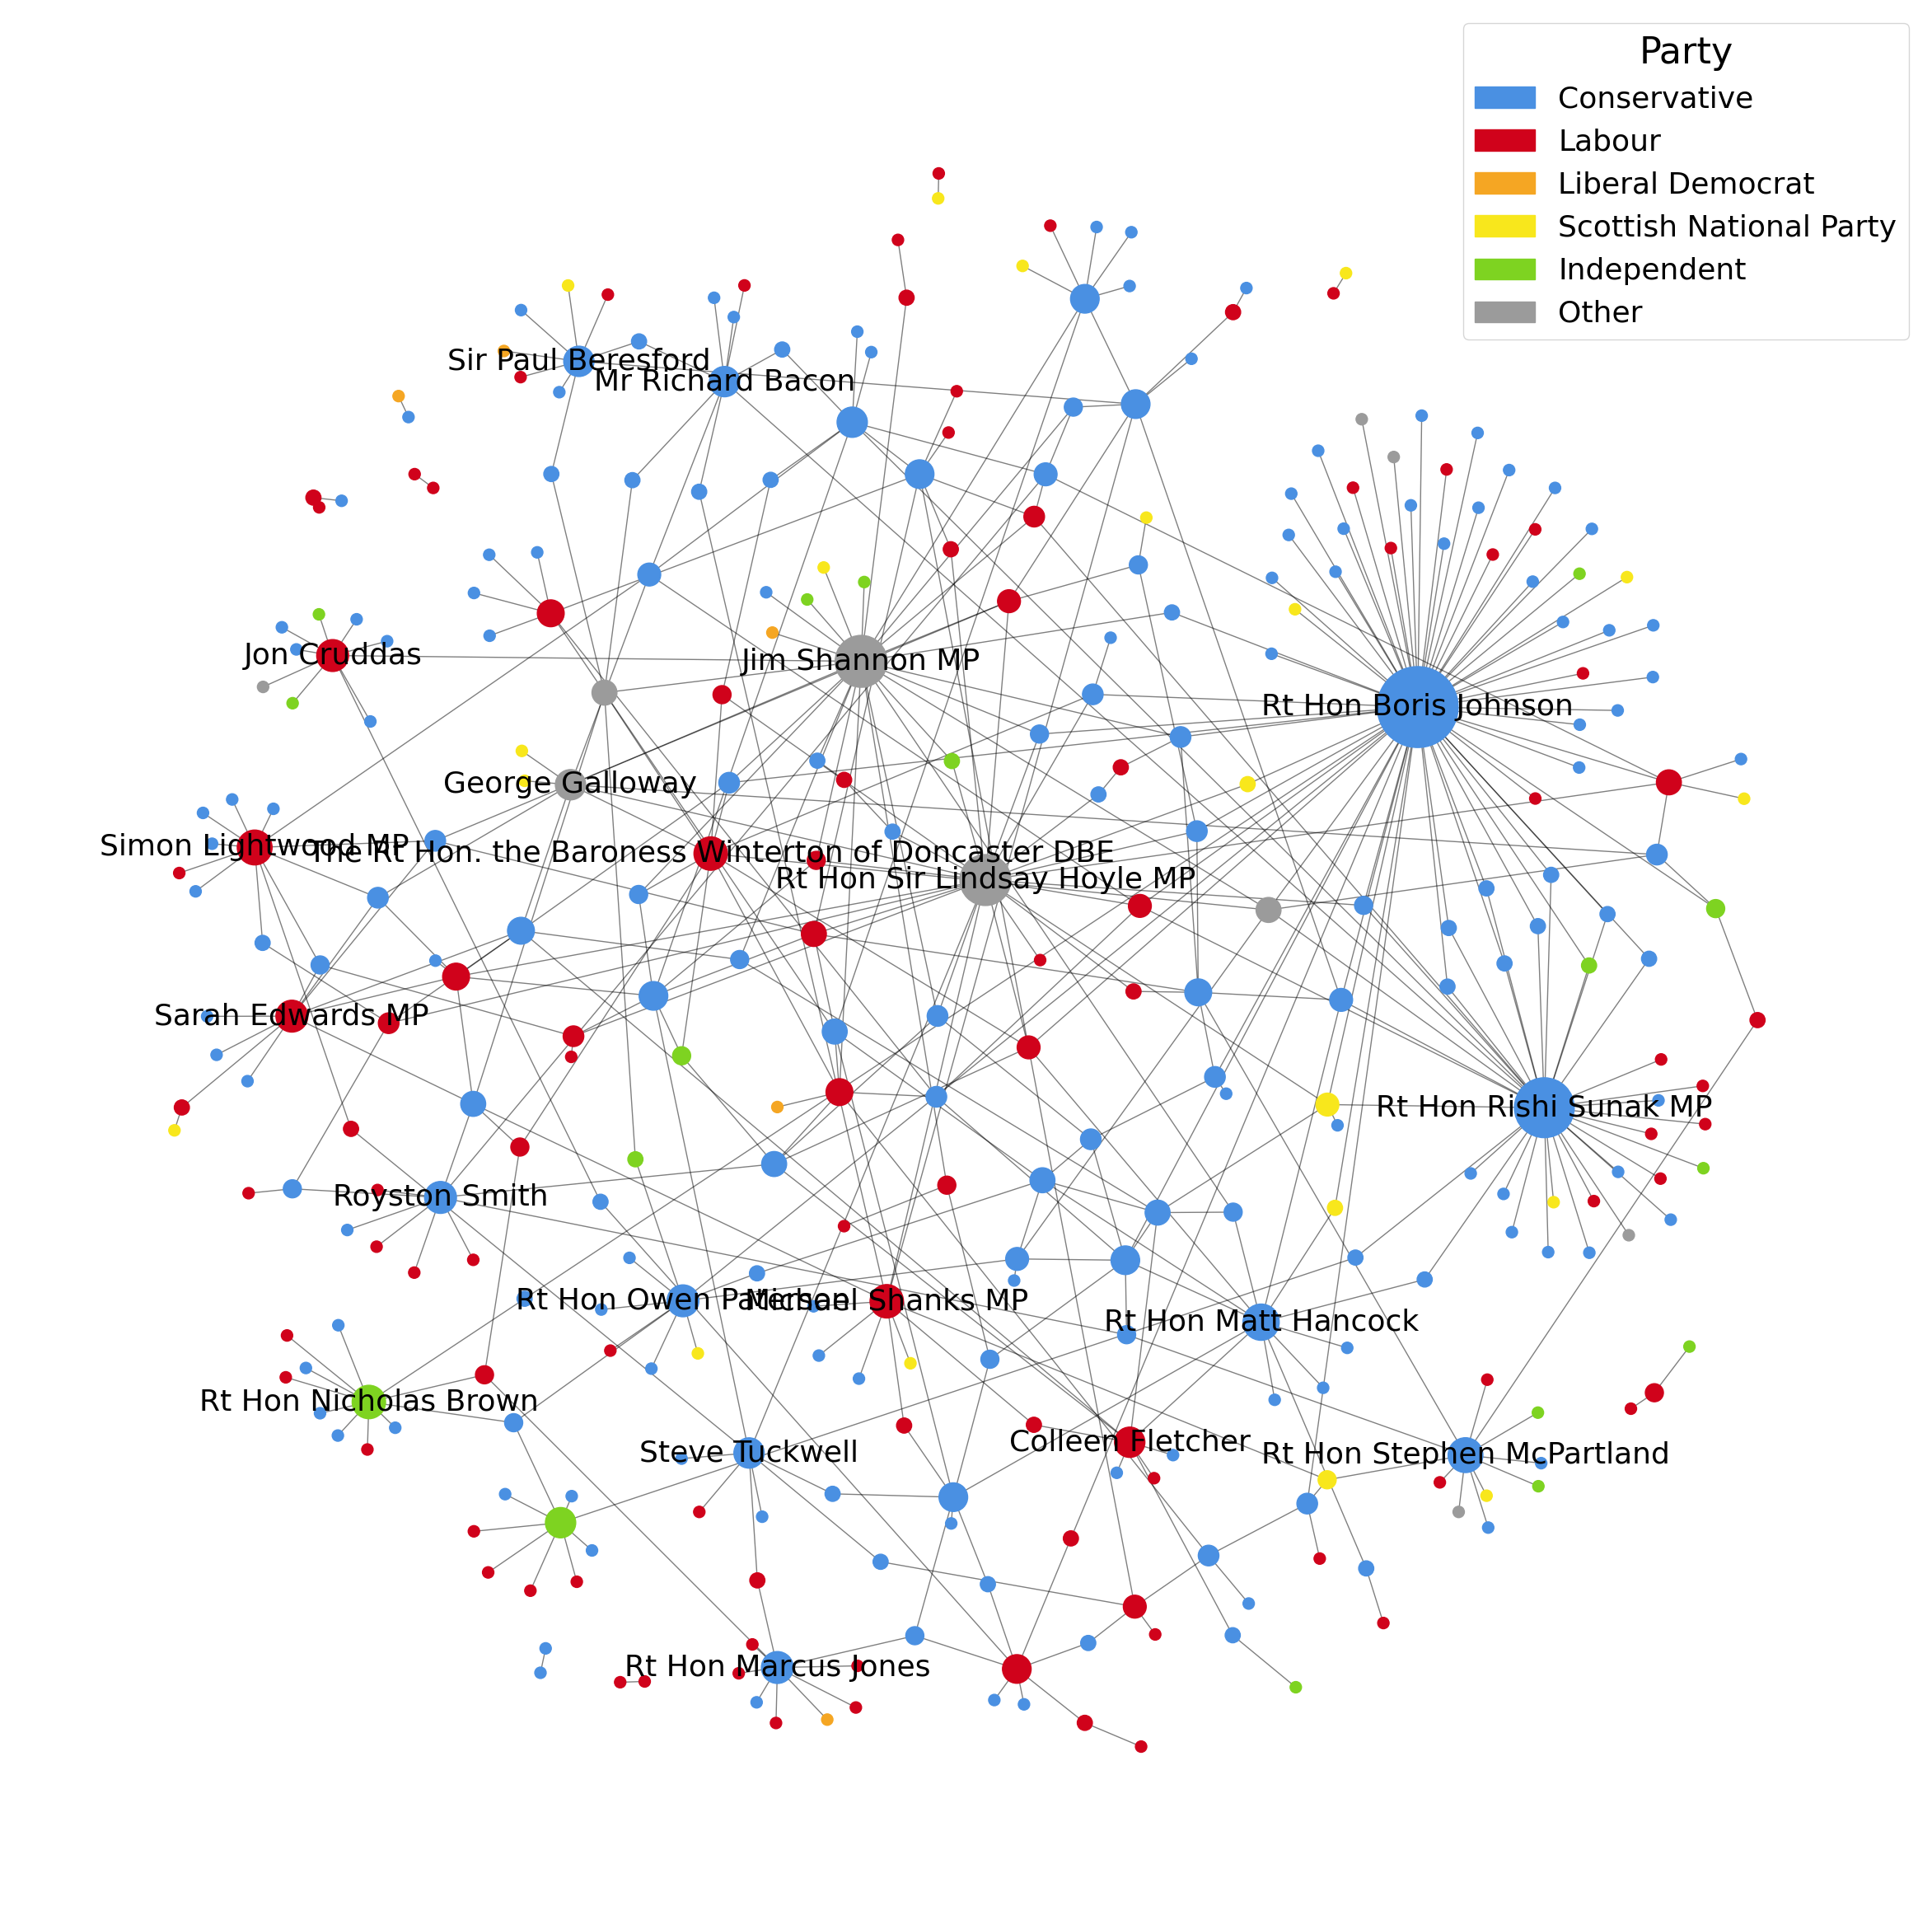

In [52]:
deg = nx.degree_centrality(backbone_G)

pos = nx.forceatlas2_layout(
    backbone_G,
    max_iter=1500,
    scaling_ratio=20.0,
    gravity=0.01,
    strong_gravity=True,
    linlog=True,
    seed=41
)
plt.figure(figsize=(30, 30))

nodes = nx.draw_networkx_nodes(
    backbone_G,
    pos,
    node_size=generate_node_sizes(backbone_G, deg),
    node_color=[party_colors.get(G_full.nodes[n].get("Party_Grouped", "Other"), "gray") for n in backbone_G.nodes()]
)

edges = nx.draw_networkx_edges(backbone_G, pos, alpha=0.5)
top_20_nodes = sorted(deg, key=deg.get, reverse=True)[:20]
top_20_nodes = [n for n in top_20_nodes if n in pos]

top_20_labels = {node: G_full.nodes[node]['FullTitle'] for node in top_20_nodes}

nx.draw_networkx_labels(backbone_G, pos, labels=top_20_labels, font_size=26)
plt.legend(handles=legend_handles, title="Party", loc="best", fontsize=26, title_fontsize=32)

plt.axis('off')


plt.show()